In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Exercise 08 - Monte Carlo simulation

#### 8.1) Lennard-Jones Potential

In [2]:
#constants
epsilon = 1.77
rm = 0.41

T = 10                        # temperature
k = 1.38064852*10**-23        # Boltzmann constant
beta = 1/k*T                  # Boltzmann factor

r_start = 0.1
iterations = 100


# variables
r_temp = 0                     # trial value
xi = 0                         # random uniform number
delta_U = 0                    # energy difference
accepted_steps = 0             # number of steps accepted


# Lennard-Jones potential for a Xe – Xe interaction
def U(r):
    return epsilon*((rm/r)**12-2*(rm/r)**6)

In [3]:
r = r_start

for step in np.arange(0.001, 0.009, 0.001):
    
    accepted_steps = 0
    
    for i in range(iterations):

        # Draw a trial value r'(s+1) as a symmetric displacement of r(s) 
        xi = random.uniform(0., 1.)
        r_temp = r + (2*xi -1)*step

        # Evaluate the energy difference
        delta_U = U(r_temp) - U(r)

        # Draw another uniform random number and evaluate
        xi = random.uniform(0., 1.)
        if(xi < np.exp(-beta*delta_U)):
            r = r_temp
            accepted_steps += 1
    
        
    acceptance_ratio = accepted_steps/iterations
    print("Step size " + str(step))
    print("Acceptance ratio " + str(acceptance_ratio) + "\n")
    
    

Step size 0.001
Acceptance ratio 0.55

Step size 0.002
Acceptance ratio 0.48

Step size 0.003
Acceptance ratio 0.5

Step size 0.004
Acceptance ratio 0.57

Step size 0.005
Acceptance ratio 0.2

Step size 0.006
Acceptance ratio 0.01

Step size 0.007
Acceptance ratio 0.0

Step size 0.008
Acceptance ratio 0.0



In [4]:
# repeat function above using temperature range

T_array = np.array([5,40,80])

step = 0.003 # reasonable value as determined previously 

for T in T_array:
    
    beta = 1/k*T
    
    r_array = np.empty(iterations)
    
    r = r_start
    
    for i in range(iterations):

        # Draw a trial value r'(s+1) as a symmetric displacement of r(s) 
        xi = random.uniform(0., 1.)
        r_temp = r + (2*xi -1)*step

        # Evaluate the energy difference
        delta_U = U(r_temp) - U(r)

        # Draw another uniform random number and evaluate
        xi = random.uniform(0., 1.)
        if(xi < np.exp(-beta*delta_U)):
            r = r_temp
            accepted_steps += 1
        
        r_array[i] = r
        

#### 8.2) 2D-potential

First we show the potential landscape and the corresponding distribution. Afterwards we will answers the questions.

For this problem, since the units of the potential were not given, we assume that it has units of $k_{B}T$. For the final question, we will consider different temperature values by varying a coefficient.

In [5]:
def U(x, y):
    return np.square(x**2 - 1) + (x - y) + y**2

def uu(xx):
    """Wrapper for an np.ndarray. xx[..., 0] = x, xx[..., 1] = y"""
    return U(xx[..., 0], xx[..., 1])

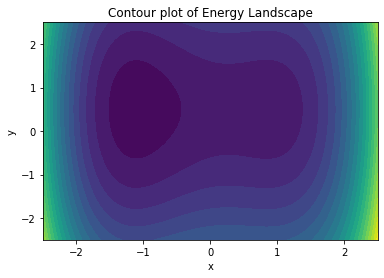

In [6]:
endpt = 2.5
numpt = 100

xx = np.linspace(-endpt, endpt, numpt)
yy = np.linspace(-endpt, endpt, numpt)
x, y = np.meshgrid(xx, yy)
z = U(x, y)

fig, ax = plt.subplots()
ax.contourf(x, y, z, levels=20)
ax.set_title("Contour plot of Energy Landscape")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

In [7]:
def Boltzmann(x, y, beta=1.0):
    return np.exp(-beta * U(x, y))

def boltzmann(xx, beta=1.0):
    """Wrapper for an np.ndarray. xx[..., 0] = x, xx[..., 1] = y"""
    return Boltzmann(xx[..., 0], xx[..., 1], beta=1.0)

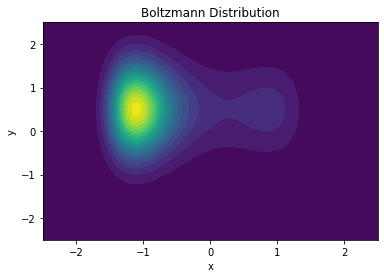

In [8]:
z = Boltzmann(x, y, beta=1.0)

fig, ax = plt.subplots()
ax.contourf(x, y, z, levels=20)
ax.set_title("Boltzmann Distribution")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Metropolis MCMC for sampling.

In [9]:
def metropolis(state, step_size=1.0, beta=1.0):
    step = (2 * np.random.rand(*state.shape) - 1) * step_size
    proposal = state + step
    diff = uu(proposal) - uu(state)
    if diff <= 0 or (np.random.rand() < np.exp(-beta * diff)):
        return proposal
    else:
        return state
    
def mcmc(initial_state, steps, step_size=1.0, beta=1.0):
    states = [initial_state]
    for _ in range(steps):
        state = metropolis(states[-1], step_size=step_size, beta=beta)
        states.append(state)
    return np.asarray(states)

In [10]:
states = mcmc(np.array([0.0, 0.0]), 10000)

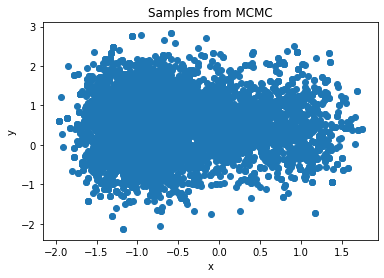

In [11]:
fig, ax = plt.subplots()
ax.scatter(*states.T)
ax.set_title("Samples from MCMC")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  


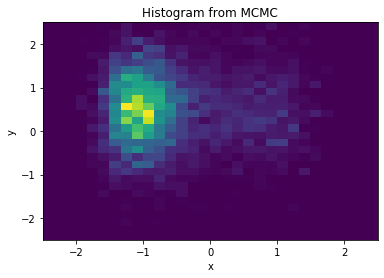

In [12]:
fig, ax = plt.subplots()
ax.hist2d(*states.T, bins=30, normed=True, range=((-endpt, endpt), (-endpt, endpt)))
ax.set_title("Histogram from MCMC")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Step size and effect on acceptance ratio. As step size decreases, we accept more proposals; however, we do not get good "mixing." Mixing colloquially means visiting a significant portion of the distribution with high regularity.

In [13]:
def acceptance(samples):
    accepted = []
    for i in range(len(samples)):
        try:
            if np.all(np.equal(samples[i], samples[i+1])):
                accepted.append(False)
            else:
                accepted.append(True)
        except IndexError:
            break
    return accepted

def acceptance_ratio(samples):
    arr = acceptance(samples)
    return sum(arr)/len(arr)

In [14]:
ar = []
delta = np.linspace(0.01, 1.0, 25)
for d in delta:
    smps = mcmc(np.array([0.0, 0.0]), 10000, step_size=d)
    ar.append(acceptance_ratio(smps))

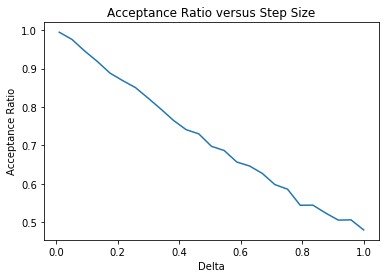

In [15]:
fig, ax = plt.subplots()
ax.plot(delta, ar)
ax.set_title("Acceptance Ratio versus Step Size")
ax.set_xlabel("Delta")
ax.set_ylabel("Acceptance Ratio")
plt.show()

We alter the temperature by altering the $\beta$ coefficient. As stated above, there are no units for this energy, so we select $\beta$ between 1.0 and 0.25. This represents a temperature change of 4 times the initial temperature. We have already calculated $\beta$=1.0 above. 

In [16]:
beta = 0.75
smps = mcmc(np.array([0.0, 0.0]), 10000, step_size=1.0, beta=beta)

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  


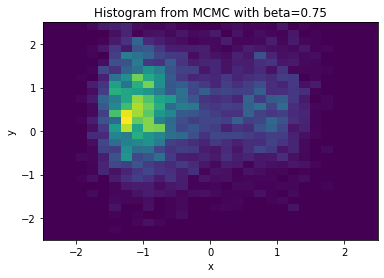

In [17]:
fig, ax = plt.subplots()
ax.hist2d(*smps.T, bins=30, normed=True, range=((-endpt, endpt), (-endpt, endpt)))
ax.set_title(f"Histogram from MCMC with beta={beta}")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

In [18]:
beta = 0.5
smps = mcmc(np.array([0.0, 0.0]), 10000, step_size=1.0, beta=beta)

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  


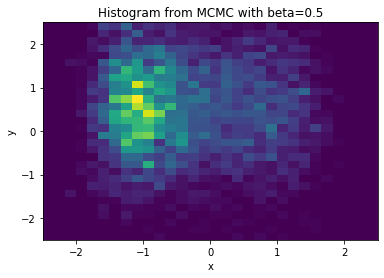

In [19]:
fig, ax = plt.subplots()
ax.hist2d(*smps.T, bins=30, normed=True, range=((-endpt, endpt), (-endpt, endpt)))
ax.set_title(f"Histogram from MCMC with beta={beta}")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

In [20]:
beta = 0.25
smps = mcmc(np.array([0.0, 0.0]), 10000, step_size=1.0, beta=beta)

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  


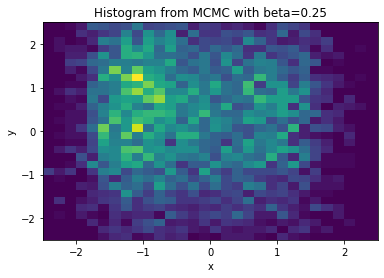

In [21]:
fig, ax = plt.subplots()
ax.hist2d(*smps.T, bins=30, normed=True, range=((-endpt, endpt), (-endpt, endpt)))
ax.set_title(f"Histogram from MCMC with beta={beta}")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Now we calculate the population of the minimum energy state (-1.1, 0.5) as a function of 1/$\beta$. We are using the density parameter with the same range, so it really is a probability of occupancy.

In [22]:
h, x, y = np.histogram2d(*smps.T, bins=30, normed=True, range=((-endpt, endpt), (-endpt, endpt)))
print(f"Left and bottom edges ({x[8]:.2f}, {y[18]}) ")
print(f"Occupation of state {h[8, 18]}")

Left and bottom edges (-1.17, 0.5) 
Occupation of state 0.07790521532135905


In [23]:
occu = []
beta = np.linspace(0.25, 1.0, 25)
for b in beta:
    smps = mcmc(np.array([0.0, 0.0]), 50000, step_size=1.0, beta=b)
    h, x, y = np.histogram2d(*smps.T, bins=30, normed=True, range=((-endpt, endpt), (-endpt, endpt)))
    occu.append(h[8, 18])

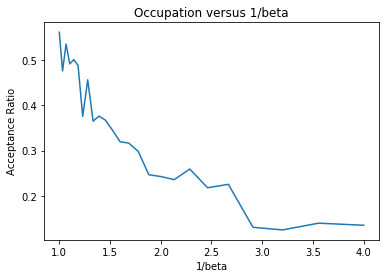

In [24]:
fig, ax = plt.subplots()
ax.plot(1/beta, occu)
ax.set_title("Occupation versus 1/beta")
ax.set_xlabel("1/beta")
ax.set_ylabel("Acceptance Ratio")
plt.show()